In [1]:
## Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
## Reference frequency
omega = 62.831853072

## Need to grab periods from config files
T5 = 0.32699999999893814

## Need to grab frequencies from config file
omegas5 = [0,62.831853072,70.84,-70.84,-62.831853072]

In [3]:
## Get data from file
df1 = pd.read_csv('Unsteady/history.csv').rename(columns=lambda x: x.strip())
df2 = pd.read_csv('Unsteady/history_06221.csv').rename(columns=lambda x: x.strip())
df3 = pd.read_csv('Unsteady/history_31201.csv').rename(columns=lambda x: x.strip())

df2['"Cur_Time"'] = df2['"Cur_Time"']+6221*1e-5
df3['"Cur_Time"'] = df3['"Cur_Time"']+31201*1e-5

unsteady_df = pd.concat([df1,df2,df3], axis=0)
hb5_df = pd.read_csv('HB/HB_output.csv',index_col=False)

/tmp/ipykernel_3802057/1748106002.py:10: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  hb5_df = pd.read_csv('HB/HB_output.csv',index_col=False)


In [4]:
## Process data
all_times = unsteady_df['"Cur_Time"'].to_numpy()*omega
all_lift = unsteady_df['"CL"'].to_numpy()
all_drag = unsteady_df['"CD"'].to_numpy()

N5 = len(hb5_df['time_instance'])
hb5_times = hb5_df['time_instance'].to_numpy()*T5*omega/N5
hb5_lift = hb5_df['CL'].to_numpy()
hb5_drag = hb5_df['CD'].to_numpy()

## Normalize lift
#MACH_NUMBER= 0.7
#AOA= 03.0
#FREESTREAM_PRESSURE= 100
#FREESTREAM_TEMPERATURE= 540

chord = 16
span = 32
area = chord*span #rectangular

all_lift = all_lift/(area)
all_drag = all_drag/(area)
hb5_lift = hb5_lift/(area)
hb5_drag = hb5_drag/(area)

In [5]:
## Define functions for Einv and interpolation

#  Einv calculation
def get_Einv(T,N,K,omegas):
    Einv = np.zeros((N,K),dtype=complex)
    for n in range(0,N):
        for k in range(0,K):
            Einv[n,k] = complex(np.cos(omegas[k]*n*T/N),np.sin(omegas[k]*n*T/N))
    return Einv

#  Interpolation
def get_interp(T,max_time,n_times,omegas,hb_lift):
    Einv = get_Einv(T,len(omegas),len(omegas),omegas)
    coeffs = np.squeeze(np.asarray(np.mat(np.linalg.inv(Einv))*np.mat(hb_lift).transpose()))
    times = np.linspace(0,max_time,num=n_times)
    interpol = np.zeros(len(times))
    for i in range(0,len(times)):
        for k in range(0,len(coeffs)):
            interpol[i] = interpol[i] + coeffs[k]*complex(np.cos(omegas[k]*times[i]),np.sin(omegas[k]*times[i]))
    return times,interpol

In [6]:
## Number of time points to interpolate
n_times = 10000

## Get interpolated values
#times5,interpol5 = get_interp(T5,max(all_times)/omega,n_times,omegas5,hb5_lift)
times5,interpoll5 = get_interp(T5,20/omega,n_times,omegas5,hb5_lift)
times5,interpold5 = get_interp(T5,20/omega,n_times,omegas5,hb5_drag)

/tmp/ipykernel_3802057/2109888424.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  interpol[i] = interpol[i] + coeffs[k]*complex(np.cos(omegas[k]*times[i]),np.sin(omegas[k]*times[i]))


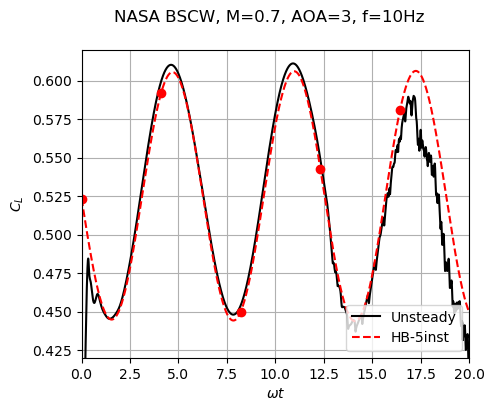

In [7]:
fig,ax = plt.subplots(1)
fig.set_size_inches(5,4)

## Plot unsteady
ax.plot(all_times,all_lift,'-k',label='Unsteady')

## Plot for HB-5inst
ax.plot(hb5_times,hb5_lift,'or',label='_hb5')
ax.plot(times5*omega,interpoll5,'--r',label='HB-5inst')

## Beautifying the plot
ax.set_xlim([0,20])
ax.set_ylim([0.42,0.62])

#ax[0].set_yticks(np.linspace(1,1.7,8))
#ax[1].set_yticks(np.linspace(0,0.15,6))

ax.grid()

ax.set_xlabel('$\omega t$');
ax.set_ylabel('$C_L$');

ax.legend(loc='lower right');
fig.suptitle('NASA BSCW, M=0.7, AOA=3, f=10Hz');